In [10]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import numpy as np
import warnings


## Load Data

### Migration influx

In [11]:
df_all = pd.read_csv(
    "../migration_rates/migration_rate_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")
df_all["value"].fillna(
    1.0, inplace=True
)  # at least 1 person per timeframe for multiplicative seasonal decomposition

with open("../migration_rates/countries.json") as buf:
    countries = list(json.load(buf).keys())

series = {c: df_all[df_all.country == c].value for c in countries}
series["NL"]


date
2010-01-01     763.0
2010-02-01     649.0
2010-03-01     768.0
2010-04-01     772.0
2010-05-01     685.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 120, dtype: float64

### Google trends

In [12]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../keywords/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../processed_data/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

keyword_ids = dataframes[countries[0]]["mean"].columns.to_list()
dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

### Macroeconomics

In [13]:
def read_gdp(filename, country_names, skiprows=10, nrows=38):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows)

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df[df["GEO/TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("GEO/TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "gdp", "GEO/TIME": "country"})
    )
    df.index = pd.to_datetime(df.index)
    return df


def read_unempl(filename, country_names, skiprows=10, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Sheet 1")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "unempl", "TIME": "country"})
        .replace({":": np.nan})
    )

    df.index = pd.to_datetime(df.index)
    return df


def read_share_young_pop(filename, country_names, skiprows=9, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Share Young Pop")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "share_young_pop", "TIME": "country"})
    )

    df.index = pd.to_datetime(df.index)
    return df


with open("../macroeconomics/country_names.json") as f:
    country_names = json.load(f)

df_gdp = read_gdp("../macroeconomics/GDP_pc_quart.xls", country_names)
df_unempl = read_unempl("../macroeconomics/Unemployment_Rate_Quart.xlsx", country_names)
df_share_young_pop = read_share_young_pop("../macroeconomics/Share_Young_Population.xlsx", country_names)
df_share_young_pop
# df_unempl


country  share_young_pop
2004-01-01      BE         0.183531
2004-01-01      BG         0.209908
2004-01-01      CZ         0.225508
2004-01-01      DK         0.176100
2004-01-01      EE         0.217808
...            ...              ...
2019-01-01      LU         0.191188
2019-01-01      HU         0.171723
2019-01-01      NL         0.188275
2019-01-01      AT         0.177618
2019-01-01      PL         0.171216

[304 rows x 2 columns]

### Resample, transform and merge

In [22]:
dfs_1y = {k: df.resample("1Y").mean().diff() for k, df in dataframes.items()}
sers_1y = {k: df.resample("1Y").mean().pct_change() for k, df in series.items()}

tmp_dfs = []

for c in countries:
    tmp_dep = (
        sers_1y[c]
        .to_frame()
        .assign(country=c)
        .assign(prev1=sers_1y[c].shift(1))
        .assign(prev2=sers_1y[c].shift(2))
        .assign(prev2_neg=-sers_1y[c].shift(2))
    )
    tmp_ind = dfs_1y[c]["mean"].shift(1)
    tmp_df = pd.concat([tmp_dep, tmp_ind], axis=1)["2010-12-31":"2019-12-31"]
    tmp_dfs.append(tmp_df)

df_panel_1y = pd.concat(tmp_dfs).sort_index()

for df in [df_share_young_pop, df_gdp, df_unempl]:
    df_tmp = df.groupby([pd.Grouper(freq="1Y"), "country"]).mean().shift(1).pct_change()
    df_panel_1y = df_panel_1y.join(
        df_tmp, on=[df_panel_1y.index, df_panel_1y["country"]], how="left"
    )

df_panel_1y


value country     prev1     prev2  prev2_neg          2  \
date                                                                     
2010-12-31       NaN      FR       NaN       NaN        NaN  15.428571   
2010-12-31       NaN      LV       NaN       NaN        NaN   0.000000   
2010-12-31       NaN      PL       NaN       NaN        NaN   1.142857   
2010-12-31       NaN      SI       NaN       NaN        NaN   0.000000   
2010-12-31       NaN      LT       NaN       NaN        NaN   0.000000   
...              ...     ...       ...       ...        ...        ...   
2019-12-31  0.060538      GB  0.023590  0.082503  -0.082503  -2.714286   
2019-12-31 -0.092664      FI -0.114530 -0.010989   0.010989   0.000000   
2019-12-31  0.033708      BE -0.027446 -0.007316   0.007316  -1.535714   
2019-12-31 -0.035906      RO  0.086445  0.033251  -0.033251   0.000000   
2019-12-31  0.060699      LU  0.020970 -0.064696   0.064696   0.000000   

                  10        11        12        14  ...        118        119  \
date                                                ...                         
2010-12-31 -3.809524  9.345238 -5.214286  8.750000  ...  23.726190  24.559524   
2010-12-31  0.000000  0.000000  0.000000  0.000000  ...  24.035714   3.214286   
2010-12-31  1.750000  2.904762  2.309524  5.119048  ...  22.047619  17.214286   
2010-12-31  0.000000  0.000000  0.000000  0.000000  ...   1.452381  -0.321429   
2010-12-31  0.000000  0.000000  0.000000  0.000000  ...  24.119048  -8.511905   
...              ...       ...       ...       ...  ...        ...        ...   
2019-12-31  2.345238  0.892857 -1.619048  3.869048  ...  -3.404762  -0.916667   
2019-12-31  0.000000  0.000000  0.000000  0.000000  ...   1.523810  -0.047619   
2019-12-31  0.000000 -1.297619  0.000000 -0.464286  ...   1.202381  -1.464286   
2019-12-31  0.000000 -1.988095 -4.154762  8.821429  ...   6.535714   1.809524   
2019-12-31  0.000000 -4.500000  0.000000  0.000000  ...   4.880952   4.785714   

                  121        122        123        124        125  \
date                                                                
2010-12-31  -2.130952  -0.440476  -3.357143  -0.440476   2.142857   
2010-12-31  12.345238  -4.785714  10.761905   7.178571  14.011905   
2010-12-31   2.261905  11.416667  15.761905  -0.714286   0.845238   
2010-12-31  -0.797619   0.380952  12.583333   2.976190  -1.642857   
2010-12-31   6.142857  -0.083333  -5.559524  -9.583333   1.392857   
...               ...        ...        ...        ...        ...   
2019-12-31  -1.178571   2.166667  -1.797619   4.678571  -3.071429   
2019-12-31   2.535714   6.571429  12.904762   8.285714   5.880952   
2019-12-31  -1.000000   1.369048  -1.821429   9.166667   7.250000   
2019-12-31   4.761905   5.345238   2.023810   8.916667  -4.500000   
2019-12-31   1.821429  -6.273810   2.261905  12.630952   8.809524   

            share_young_pop       gdp    unempl  
date                                             
2010-12-31        -0.135591  0.522569 -0.576826  
2010-12-31        -0.113760  7.744751 -0.754902  
2010-12-31        -0.140286  3.514085 -0.744544  
2010-12-31              NaN  5.463651  0.241007  
2010-12-31        -0.297086 -0.267609 -0.427101  
...                     ...       ...       ...  
2019-12-31              NaN -0.174661  0.257463  
2019-12-31              NaN  0.245639  2.162921  
2019-12-31         0.005320  1.724893 -0.306513  
2019-12-31              NaN  0.494236  0.969697  
2019-12-31         0.144721 -0.411130 -0.366834  

[270 rows x 56 columns]

## Evaluation functions and common variables

In [23]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import feature_selection
from sklearn import compose
from sklearn import impute

t_min = "2012-12-31"
t_max = "2019-12-31"
t_split_lower = "2017-12-31"
t_split_upper = "2018-12-31"

scoring = ["neg_mean_absolute_percentage_error", "neg_root_mean_squared_error", "r2"]

# selected_countries = ["FR", "GB", "IT", "ES", "RO"]
selected_countries = countries


df_panel_1y = df_panel_1y[df_panel_1y.country.isin(selected_countries)]
dummies = pd.get_dummies(df_panel_1y["country"], drop_first=False)
dummy_cols = dummies.columns.tolist()
df_panel_1y = pd.concat([df_panel_1y, dummies], axis=1)

x = df_panel_1y.drop(columns="value")[t_min:t_max]
y = df_panel_1y["value"][t_min:t_max]

x_train = x[t_min:t_split_lower]
y_train = y[t_min:t_split_lower]
x_test = x[t_split_upper:t_max]
y_test = y[t_split_upper:t_max]

def score_cv(reg, X, y):
    scores = model_selection.cross_validate(reg, X=X, y=y, scoring=scoring)
    return pd.DataFrame(scores)

def score_test(reg, X, y):
    scores = {s: metrics.get_scorer(s)(reg, X, y) for s in scoring}
    return pd.Series(scores)

def plot_prediction(reg, X, countries=selected_countries, n_rows=6, n_cols=5, figsize=(25,25)):

    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for c, ax in zip(countries, axs.flatten()):
        df_to_plot = df_pred[df_pred.country == c]
        y_max = max(df_to_plot["pred"].max(), df_to_plot["value"].max())
        y_min = min(df_to_plot["pred"].min(), df_to_plot["value"].min())
        df_to_plot.plot(ax=ax, ylim=(y_min * 1.2, y_max * 1.2))

    return fig, axs




## Models

### Naive: country average

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.003585    0.004390                                -1.054583   
1  0.003490    0.004467                                -2.054425   
2  0.004244    0.002390                                -1.463508   
3  0.003220    0.004273                              -129.597430   
4  0.003188    0.005468                                -9.424689   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.234469 -0.825285  
1                         -0.236241  0.068693  
2                         -0.132385 -0.049013  
3                         -0.139580 -1.881838  
4                         -0.195026 -9.536528

Mean CV score:


fit_time                                    0.003545
score_time                                  0.004198
test_neg_mean_absolute_percentage_error   -28.718927
test_neg_root_mean_squared_error           -0.187540
test_r2                                    -2.444794
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.335512
neg_root_mean_squared_error          -0.170694
r2                                   -1.225447
dtype: float64

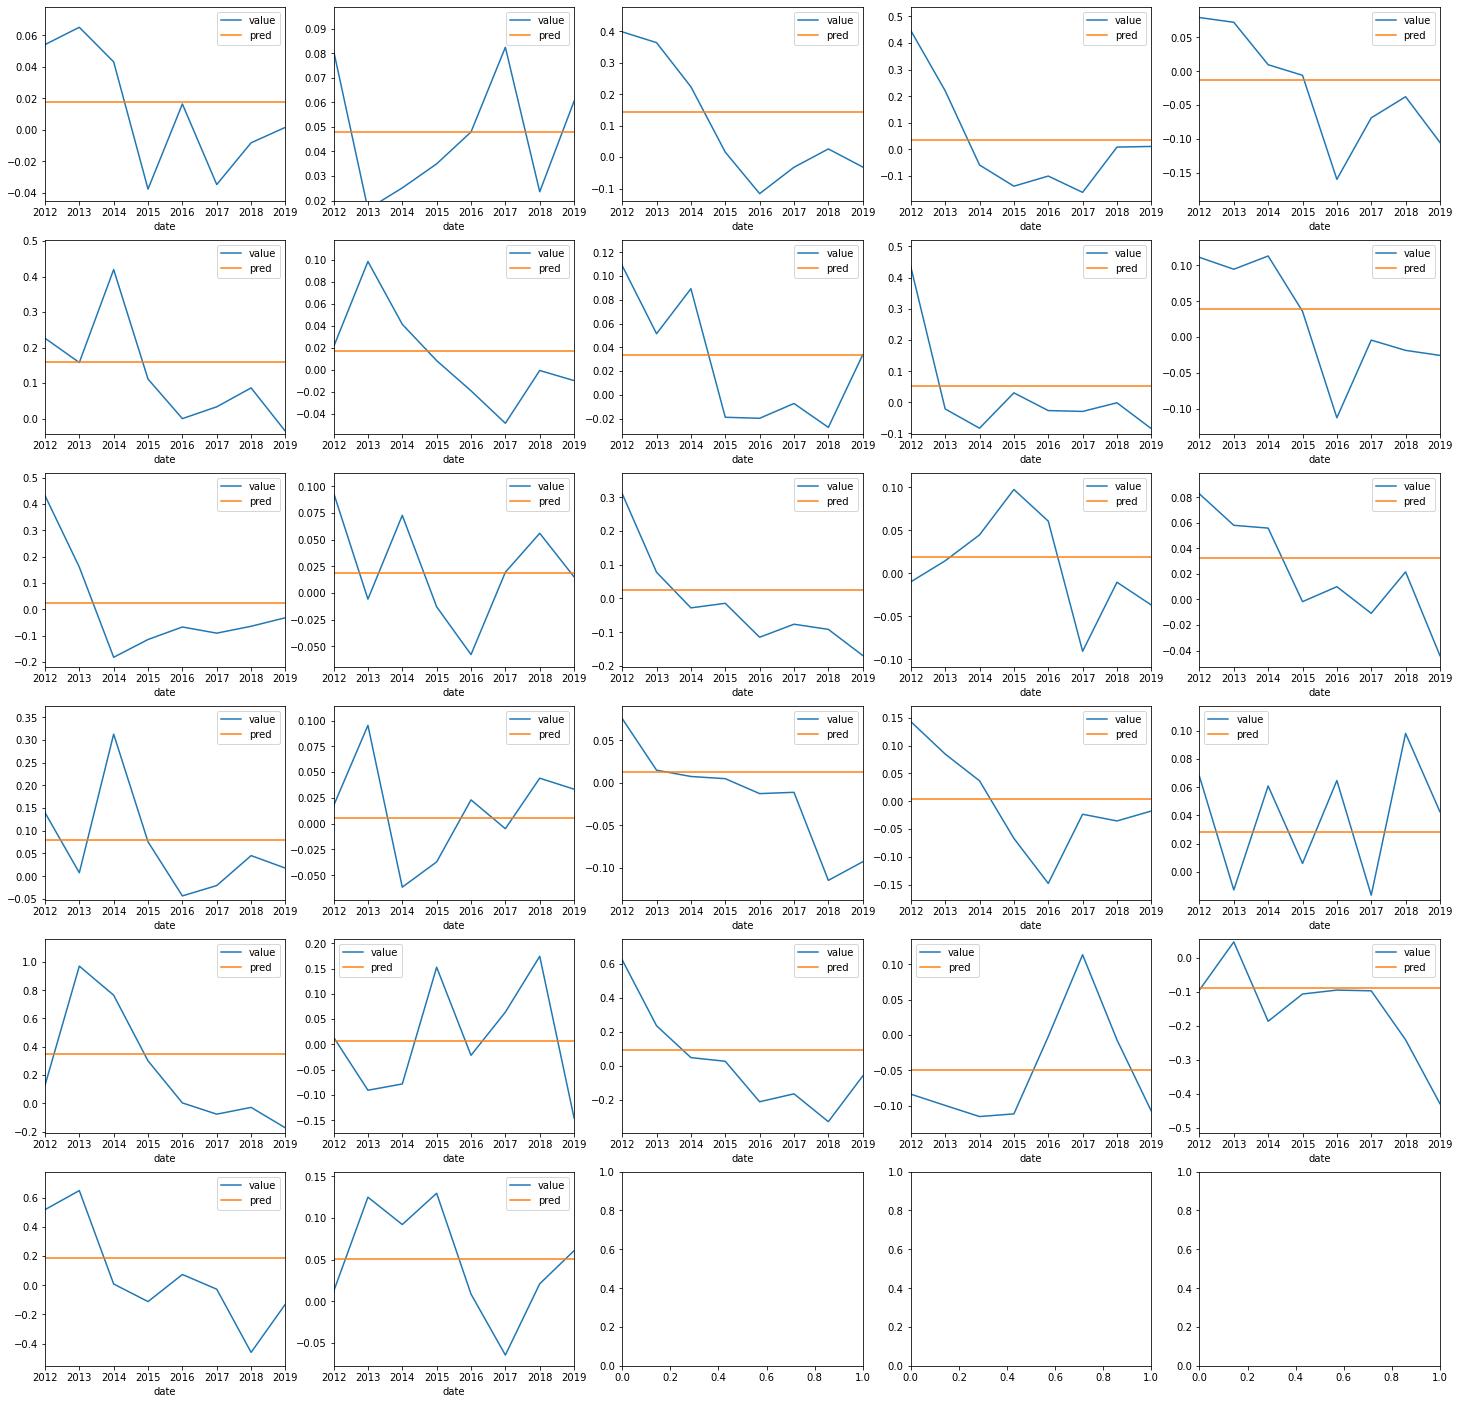

In [24]:
features = dummy_cols

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])



### Autoregressive 1 lag w fixed effects

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.010599    0.009043                                -1.234449   
1  0.010404    0.011850                                -3.121238   
2  0.021667    0.010341                                -1.517972   
3  0.019868    0.009264                               -98.485772   
4  0.017081    0.009784                                -7.442766   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.163301  0.114608  
1                         -0.213545  0.239041  
2                         -0.136745 -0.119237  
3                         -0.104604 -0.618535  
4                         -0.132390 -3.855378

Mean CV score:


fit_time                                    0.015924
score_time                                  0.010056
test_neg_mean_absolute_percentage_error   -22.360439
test_neg_root_mean_squared_error           -0.150117
test_r2                                    -0.847900
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -2.719666
neg_root_mean_squared_error          -0.115791
r2                                   -0.024074
dtype: float64

prev1    0.457320
AT       0.000940
BE       0.011512
BG       0.017351
CH       0.011241
CY       0.060646
CZ      -0.008021
DK      -0.005468
EE      -0.074994
ES      -0.032908
FI      -0.003783
FR       0.003480
GB       0.024025
GR      -0.043252
HR       0.173255
HU      -0.023019
IE      -0.010425
IT       0.057229
LT      -0.039879
LU       0.019465
LV      -0.043212
NL       0.002596
PL      -0.044246
PT      -0.015914
RO       0.066800
SE       0.002607
SI      -0.022996
SK      -0.030713
dtype: float64

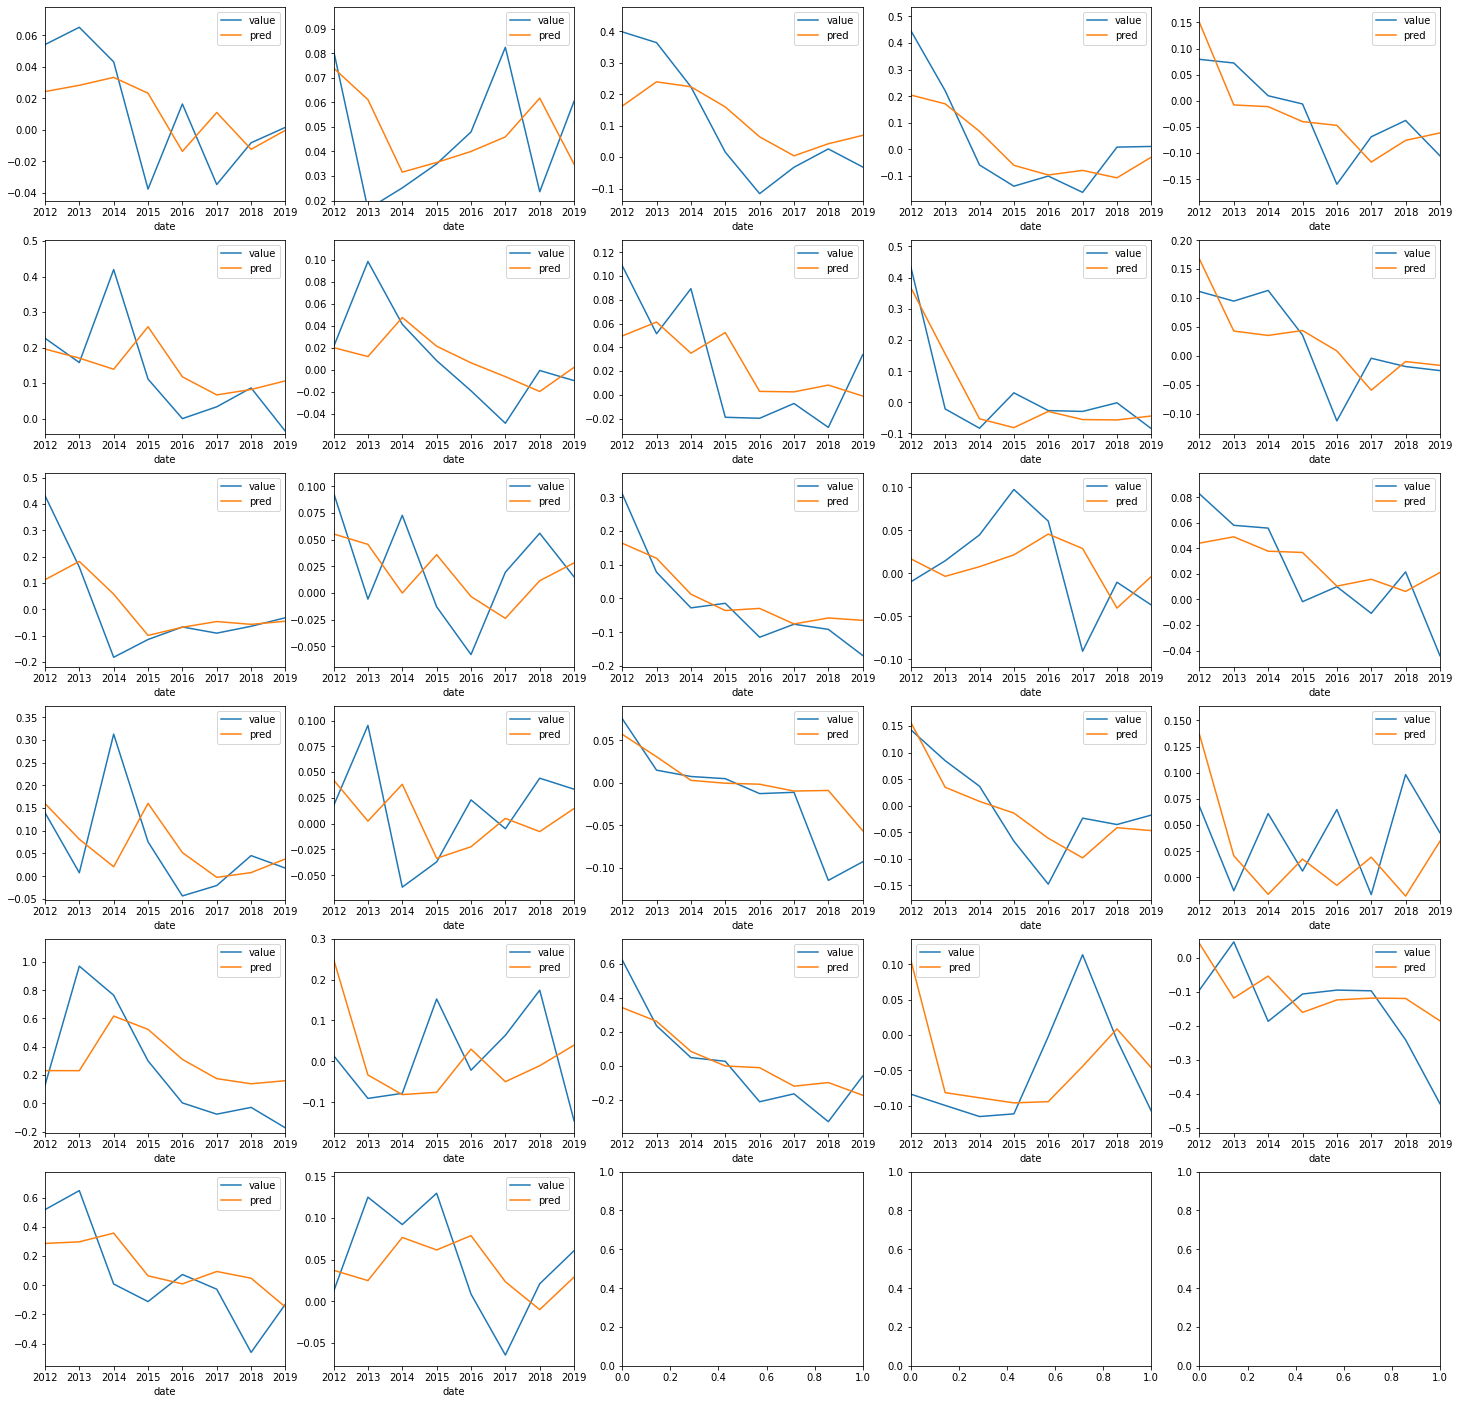

In [32]:
features = ["prev1"] + dummy_cols

reg = linear_model.LinearRegression(fit_intercept=False)

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
display(pd.Series(reg.coef_, index=features))


### Macroeconomics with fixed effects

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.026301    0.014515                                -1.986595   
1  0.019568    0.013291                                -2.057775   
2  0.019691    0.011600                                -1.922611   
3  0.022052    0.017210                              -131.973621   
4  0.021274    0.018443                               -10.999019   

   test_neg_root_mean_squared_error    test_r2  
0                         -0.271584  -1.448886  
1                         -0.236840   0.063962  
2                         -0.152428  -0.390682  
3                         -0.142222  -1.991943  
4                         -0.221956 -12.647383

Mean CV score:


fit_time                                    0.021777
score_time                                  0.015012
test_neg_mean_absolute_percentage_error   -29.787924
test_neg_root_mean_squared_error           -0.205006
test_r2                                    -3.282986
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -5.357946
neg_root_mean_squared_error          -0.156176
r2                                   -0.862991
dtype: float64

unempl            -0.010960
share_young_pop    0.529696
gdp                0.081139
AT                -0.018233
BE                -0.069490
BG                 0.097064
CH                 0.138433
CY                -0.608487
CZ                -0.085293
DK                 0.151739
EE                -0.299109
ES                 0.102922
FI                -0.001306
FR                 0.036553
GB                 0.062584
GR                -0.037518
HR                 0.477274
HU                -0.008939
IE                 0.019541
IT                -0.151151
LT                 0.145023
LU                -0.058597
LV                -0.531083
NL                 0.119130
PL                -0.211179
PT                 0.054464
RO                 0.125434
SE                -0.027341
SI                -0.313289
SK                 0.025975
dtype: float64

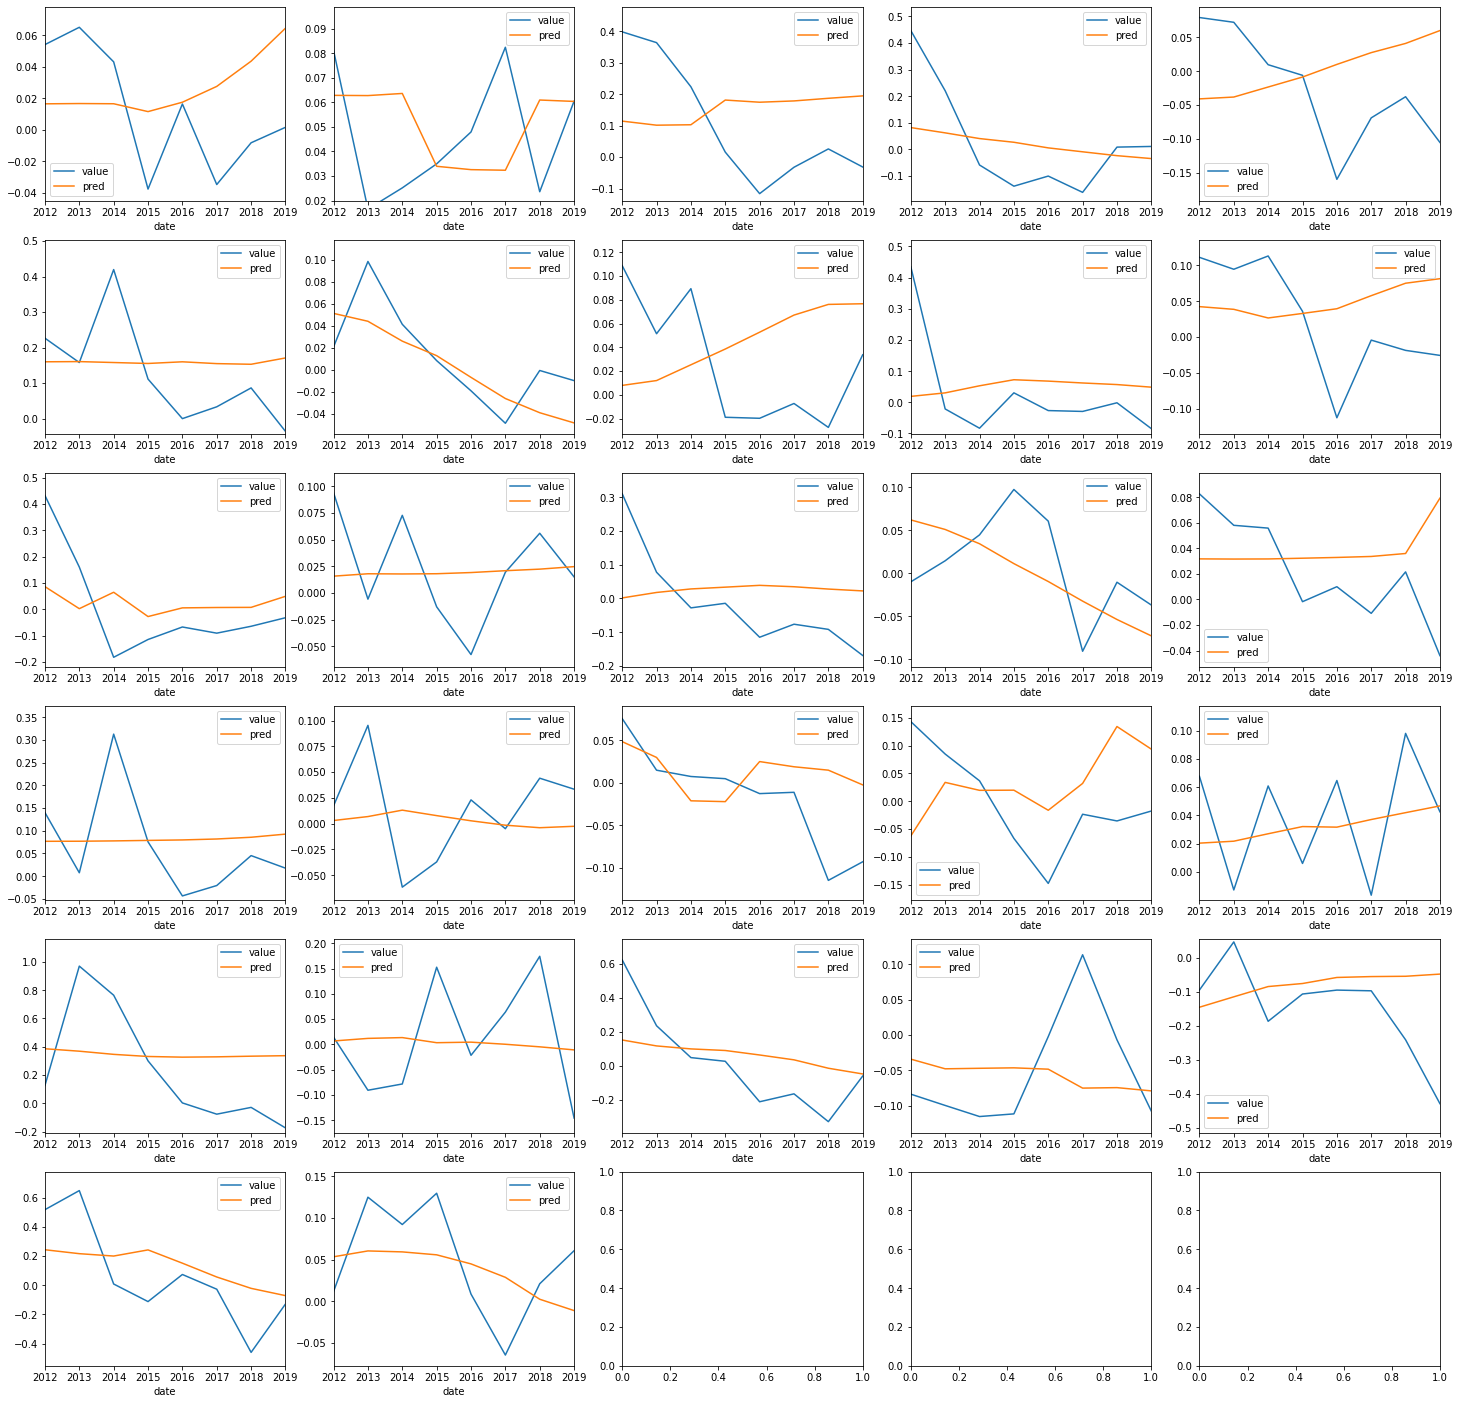

In [59]:
features = ["unempl", "share_young_pop", "gdp"] + dummy_cols

reg_core = linear_model.LinearRegression(fit_intercept=False)

reg = pipeline.make_pipeline(impute.KNNImputer(), reg_core)

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
display(pd.Series(reg_core.coef_, index=features))
fig, axs = plot_prediction(reg, x[features])


### Econ + previous

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.024450    0.014024                                -2.283905   
1  0.025398    0.012379                                -3.154788   
2  0.040896    0.015345                                -2.239193   
3  0.019139    0.017056                               -94.336712   
4  0.023265    0.017770                                -7.628356   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.217521 -0.570940  
1                         -0.214105  0.235046  
2                         -0.138482 -0.147853  
3                         -0.108743 -0.749133  
4                         -0.136098 -4.131151

Mean CV score:


fit_time                                    0.026629
score_time                                  0.015315
test_neg_mean_absolute_percentage_error   -21.928591
test_neg_root_mean_squared_error           -0.162989
test_r2                                    -1.072806
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -5.330536
neg_root_mean_squared_error          -0.123693
r2                                   -0.168619
dtype: float64

prev1              0.463057
unempl            -0.041460
share_young_pop    0.503668
gdp               -0.002653
AT                -0.040882
BE                 0.041093
BG                 0.042078
CH                 0.063374
CY                 0.131474
CZ                -0.168409
DK                 0.093907
EE                -0.107032
ES                -0.019636
FI                 0.078726
FR                 0.056402
GB                 0.026128
GR                -0.133493
HR                 0.352493
HU                -0.096179
IE                -0.031792
IT                 0.058576
LT                 0.062073
LU                -0.131532
LV                -0.031515
NL                 0.058264
PL                -0.060623
PT                -0.037115
RO                 0.102391
SE                -0.079789
SI                -0.012667
SK                -0.062461
dtype: float64

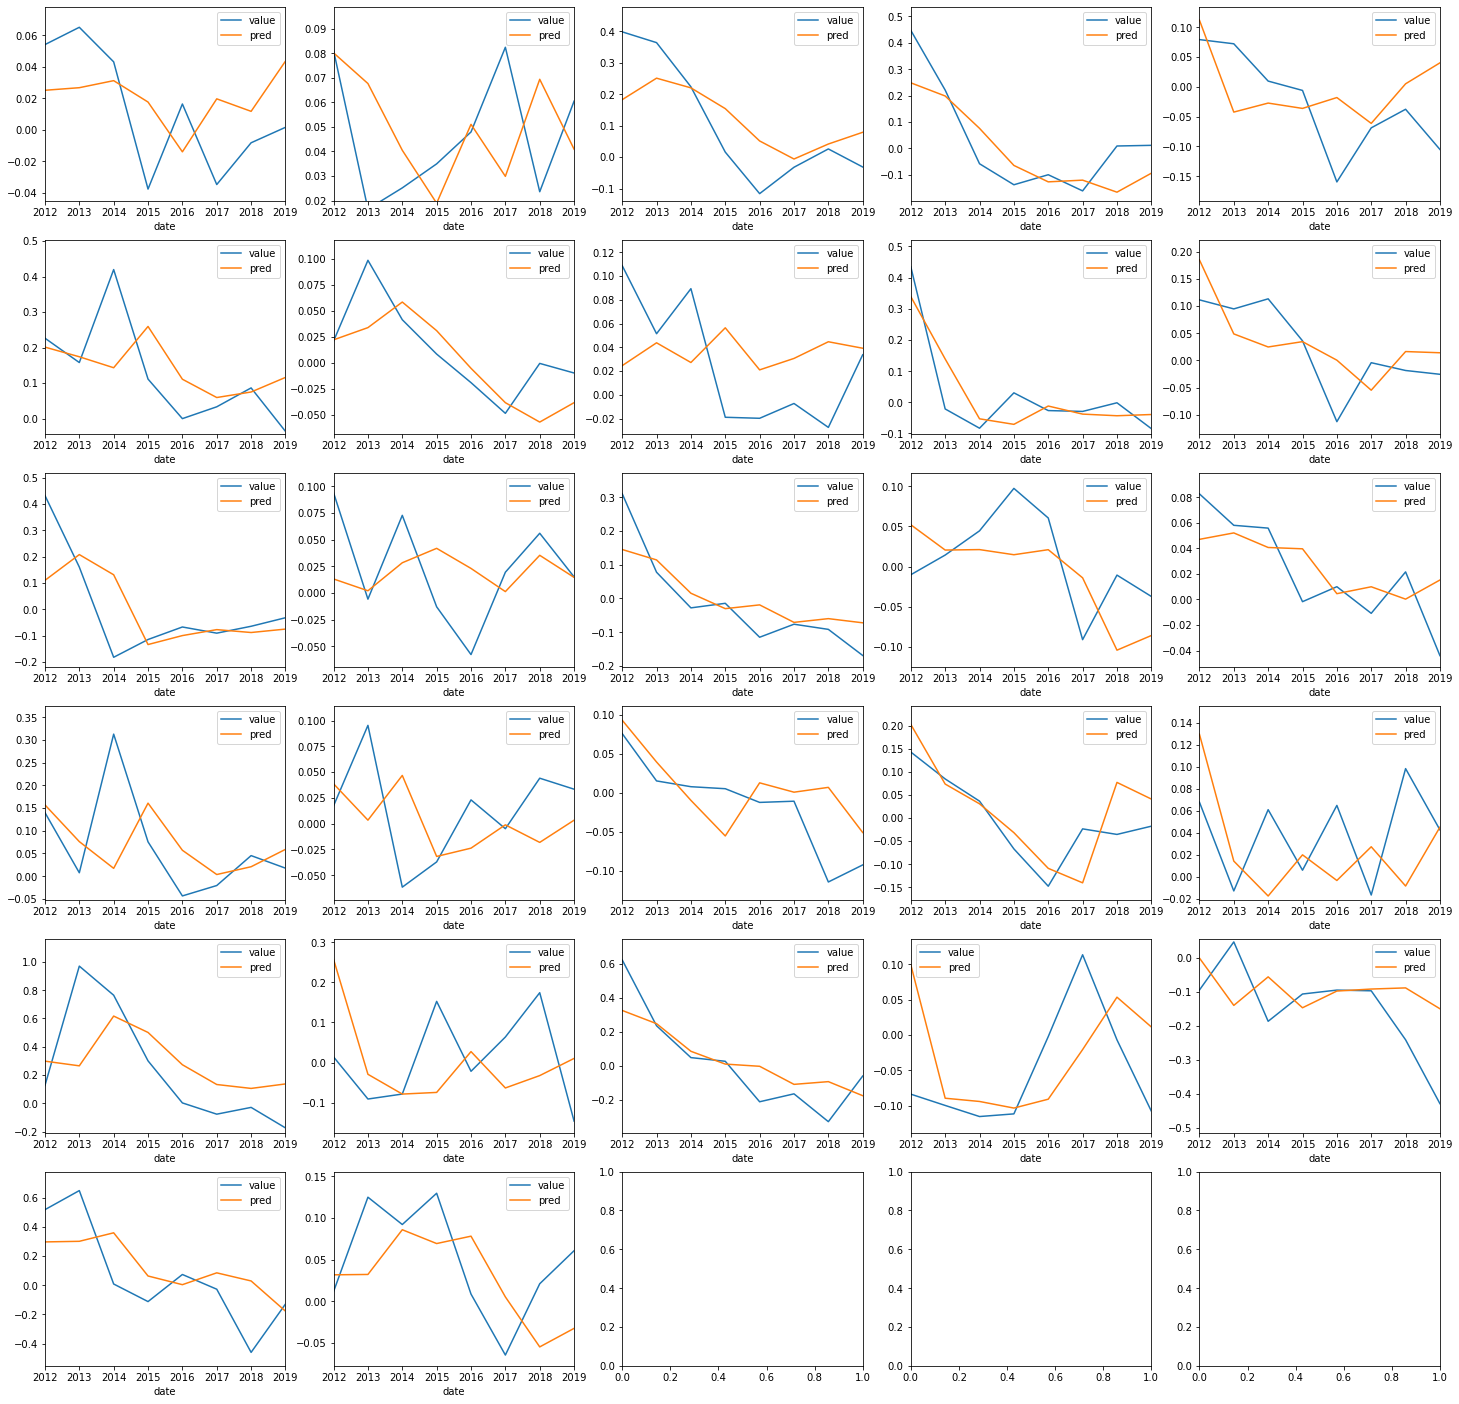

In [60]:
features = ["prev1", "unempl", "share_young_pop", "gdp"] + dummy_cols

reg_core = linear_model.LinearRegression(fit_intercept=False)

reg = pipeline.make_pipeline(impute.KNNImputer(), reg_core)

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
display(pd.Series(reg_core.coef_, index=features))
fig, axs = plot_prediction(reg, x[features])


### GTI + previous

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.016149      0.002043         0.007263        0.001903       0.001   
1        0.011014      0.001761         0.005674        0.000962        0.01   
2        0.008672      0.001944         0.003776        0.000214       0.002   
3        0.007699      0.001487         0.006019        0.002252       0.005   
4        0.009852      0.002298         0.006478        0.001946         0.1   
5        0.007045      0.002332         0.003861        0.000768         0.2   
6        0.005224      0.000291         0.003268        0.000341         0.5   
7        0.005034      0.000295         0.003196        0.000159         1.0   
8        0.004383      0.000458         0.002850        0.000363         2.0   
9        0.005624      0.000996         0.002971        0.000143         5.0   
10       0.004441      0.000354         0.003240        0.000618        10.0   

    split0_test_score  split1_test_score  split2_test_score  \
0           -0.217202          -0.266144          -0.181006   
1           -0.211618          -0.273501          -0.157631   
2           -0.212151          -0.263540          -0.161897   
3           -0.223375          -0.267736          -0.151075   
4           -0.194419          -0.257238          -0.114586   
5           -0.196543          -0.248768          -0.113412   
6           -0.211273          -0.252874          -0.123592   
7           -0.214630          -0.254937          -0.130205   
8           -0.214630          -0.254937          -0.130205   
9           -0.214630          -0.254937          -0.130205   
10          -0.214630          -0.254937          -0.130205   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           -0.113168          -0.172034        -0.189911        0.050685   
1           -0.099123          -0.132394        -0.174854        0.061510   
2           -0.099429          -0.153256        -0.178055        0.055728   
3           -0.099159          -0.130237        -0.174316        0.062074   
4           -0.092172          -0.093369        -0.150357        0.065234   
5           -0.099562          -0.096380        -0.150933        0.061114   
6           -0.111250          -0.109008        -0.161599        0.059235   
7           -0.118705          -0.117310        -0.167157        0.056845   
8           -0.118705          -0.117310        -0.167157        0.056845   
9           -0.118705          -0.117310        -0.167157        0.056845   
10          -0.118705          -0.117310        -0.167157        0.056845   

    rank_test_score  
0                11  
1                 9  
2                10  
3                 8  
4                 1  
5                 2  
6                 3  
7                 4  
8                 4  
9                 4  
10                4

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.006335    0.005285                                -1.432855   
1  0.007289    0.004200                                -1.621047   
2  0.005765    0.004392                                -2.173291   
3  0.005916    0.005011                               -24.878388   
4  0.007028    0.006206                                -3.863242   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.194419 -0.254974  
1                         -0.257238 -0.104214  
2                         -0.114586  0.214109  
3                         -0.092172 -0.256680  
4                         -0.093369 -1.414992

Mean CV score:


fit_time                                   0.006466
score_time                                 0.005019
test_neg_mean_absolute_percentage_error   -6.793764
test_neg_root_mean_squared_error          -0.150357
test_r2                                   -0.363350
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.526895
neg_root_mean_squared_error          -0.133414
r2                                   -0.359519
dtype: float64

LASSO Coefficients:
prev1    0.000000
2       -0.000000
10       0.000000
11      -0.000000
12       0.000000
14      -0.000000
15       0.000000
16       0.000000
17       0.000000
18      -0.000000
19       0.005667
20      -0.000000
21       0.000000
22       0.000000
24       0.000438
26       0.000000
28       0.000000
32      -0.000000
33       0.000000
37       0.000000
38      -0.000000
39       0.003857
41      -0.000000
42      -0.000000
43      -0.000000
44      -0.000000
48       0.000000
49       0.000000
51       0.000000
52       0.000000
54       0.000000
55      -0.000000
56      -0.000000
57      -0.000000
58       0.000000
59      -0.000000
60      -0.000000
112     -0.000000
113      0.000000
114     -0.000000
115      0.004993
117      0.000000
118      0.000000
119     -0.000000
121     -0.000000
122     -0.000000
123      0.000000
124     -0.000000
125     -0.000000
AT      -0.000000
BE      -0.000000
BG       0.000000
CH      -0.000000
CY       0.000000
CZ      

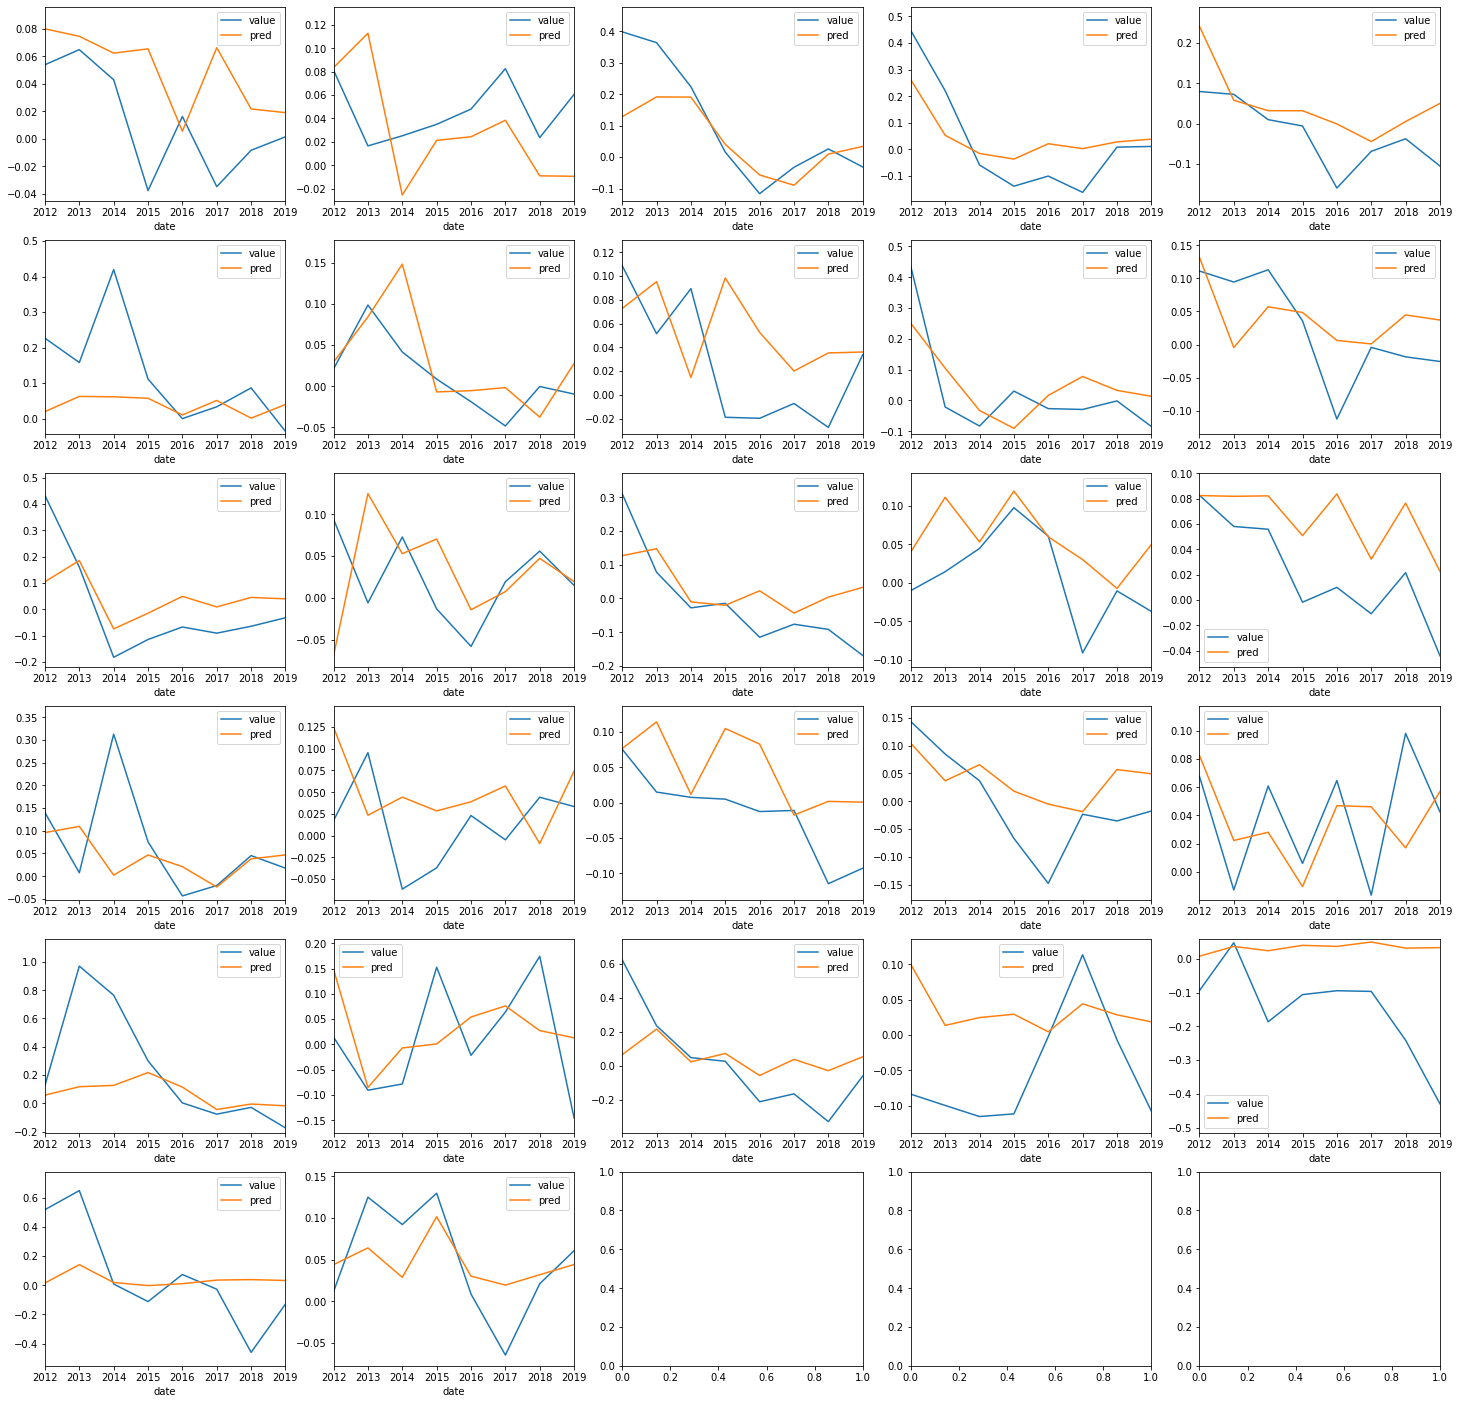

In [50]:
features = ["prev1"] + keyword_ids + dummy_cols

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.Lasso(normalize=False)
params = {
    "alpha": [0.001, 0.01, 0.002, 0.005, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())



### GTI only

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.010943      0.001998         0.004753        0.000932       0.001   
1        0.006366      0.000716         0.003826        0.000291        0.01   
2        0.005363      0.000673         0.003315        0.000508        0.02   
3        0.004209      0.000347         0.002820        0.000293        0.05   
4        0.003966      0.000149         0.002554        0.000074         0.1   
5        0.003876      0.000111         0.002557        0.000152         0.2   
6        0.003691      0.000253         0.002353        0.000081         0.5   
7        0.003397      0.000028         0.002171        0.000055         1.0   
8        0.003575      0.000197         0.002239        0.000059         2.0   
9        0.003593      0.000144         0.002259        0.000075         5.0   
10       0.004157      0.000357         0.002661        0.000168        10.0   

    split0_test_score  split1_test_score  split2_test_score  \
0           -0.237148          -0.290945          -0.203624   
1           -0.211619          -0.273502          -0.157631   
2           -0.200621          -0.271278          -0.145721   
3           -0.191755          -0.266989          -0.124929   
4           -0.194419          -0.257238          -0.114586   
5           -0.196543          -0.248768          -0.113412   
6           -0.211273          -0.252874          -0.123592   
7           -0.214630          -0.254937          -0.130205   
8           -0.214630          -0.254937          -0.130205   
9           -0.214630          -0.254937          -0.130205   
10          -0.214630          -0.254937          -0.130205   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           -0.119648          -0.198936        -0.210060        0.055885   
1           -0.100121          -0.132395        -0.175054        0.061265   
2           -0.094937          -0.115793        -0.165670        0.063661   
3           -0.094173          -0.103838        -0.156337        0.064970   
4           -0.092172          -0.093369        -0.150357        0.065234   
5           -0.099562          -0.096380        -0.150933        0.061114   
6           -0.111250          -0.109008        -0.161599        0.059235   
7           -0.118705          -0.117310        -0.167157        0.056845   
8           -0.118705          -0.117310        -0.167157        0.056845   
9           -0.118705          -0.117310        -0.167157        0.056845   
10          -0.118705          -0.117310        -0.167157        0.056845   

    rank_test_score  
0                11  
1                10  
2                 5  
3                 3  
4                 1  
5                 2  
6                 4  
7                 6  
8                 6  
9                 6  
10                6

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.006164    0.004875                                -1.432855   
1  0.005206    0.004407                                -1.621047   
2  0.004540    0.003997                                -2.173291   
3  0.008624    0.007574                               -24.878388   
4  0.005409    0.004515                                -3.863242   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.194419 -0.254974  
1                         -0.257238 -0.104214  
2                         -0.114586  0.214109  
3                         -0.092172 -0.256680  
4                         -0.093369 -1.414992

Mean CV score:


fit_time                                   0.005988
score_time                                 0.005074
test_neg_mean_absolute_percentage_error   -6.793764
test_neg_root_mean_squared_error          -0.150357
test_r2                                   -0.363350
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.526895
neg_root_mean_squared_error          -0.133414
r2                                   -0.359519
dtype: float64

LASSO Coefficients:
2     -0.000000
10     0.000000
11    -0.000000
12     0.000000
14    -0.000000
15     0.000000
16     0.000000
17     0.000000
18    -0.000000
19     0.005667
20    -0.000000
21     0.000000
22     0.000000
24     0.000438
26     0.000000
28     0.000000
32    -0.000000
33     0.000000
37     0.000000
38    -0.000000
39     0.003857
41    -0.000000
42    -0.000000
43    -0.000000
44    -0.000000
48     0.000000
49     0.000000
51     0.000000
52     0.000000
54     0.000000
55    -0.000000
56    -0.000000
57    -0.000000
58     0.000000
59    -0.000000
60    -0.000000
112   -0.000000
113    0.000000
114   -0.000000
115    0.004993
117    0.000000
118    0.000000
119   -0.000000
121   -0.000000
122   -0.000000
123    0.000000
124   -0.000000
125   -0.000000
AT    -0.000000
BE    -0.000000
BG     0.000000
CH    -0.000000
CY     0.000000
CZ    -0.000000
DK    -0.000000
EE    -0.000000
ES    -0.000000
FI    -0.000000
FR    -0.000000
GB     0.000000
GR    -0.000000
HR  

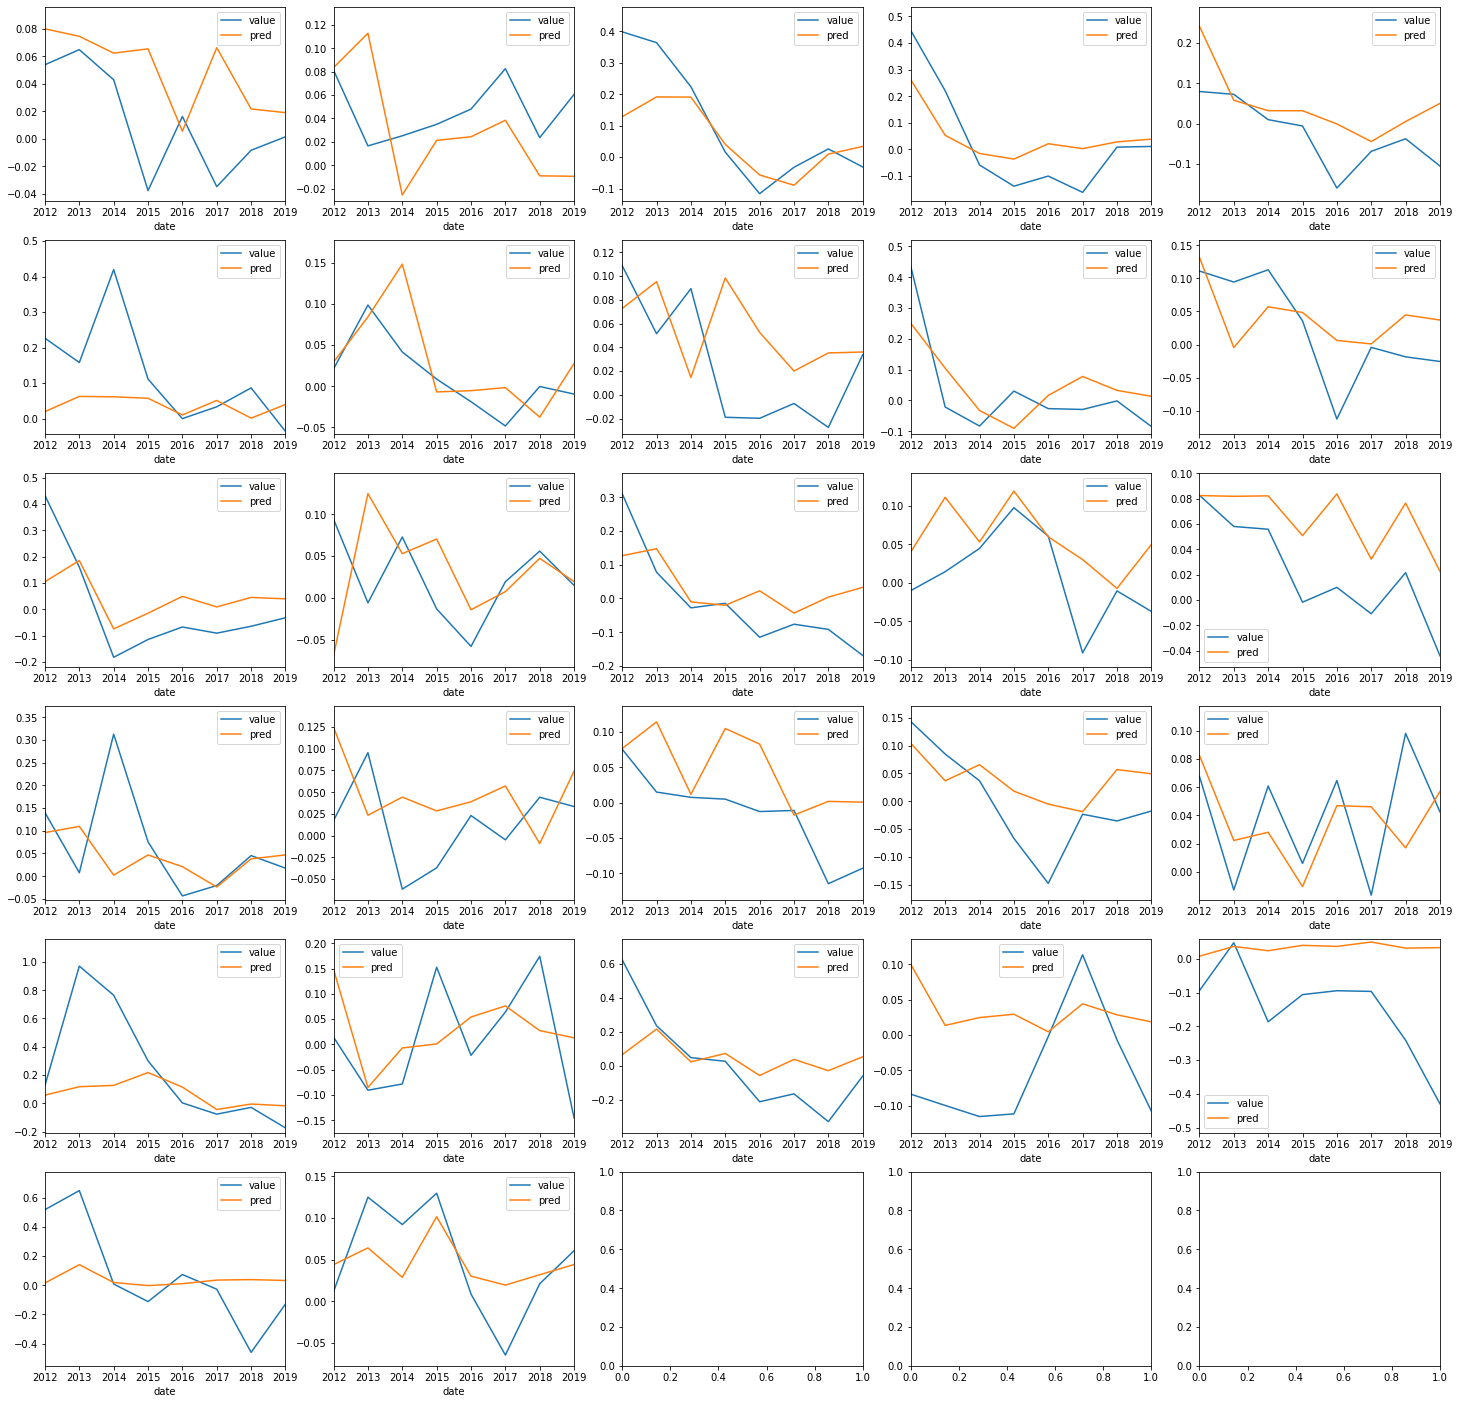

In [51]:
features = keyword_ids + dummy_cols

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.Lasso(normalize=False)
params = {
    "alpha": [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())



### GTI + econ

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037046015357797835, tolerance: 0.00041020526602560586
  model = cd_fast.enet_coordinate_descent(


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.040251      0.010213         0.013143        0.002576   
1        0.022981      0.003457         0.010117        0.002495   
2        0.017968      0.004067         0.008188        0.000709   
3        0.014786      0.002354         0.008471        0.001180   
4        0.013707      0.002126         0.006446        0.000984   
5        0.014664      0.001808         0.008575        0.001716   
6        0.013723      0.001685         0.006710        0.001391   
7        0.015527      0.002106         0.007105        0.001506   
8        0.013286      0.002074         0.007200        0.001777   
9        0.016495      0.004426         0.010859        0.003027   
10       0.035282      0.038901         0.016424        0.015262   

   param_lasso__alpha  split0_test_score  split1_test_score  \
0              0.0001          -0.304381          -0.317846   
1               0.001          -0.237684          -0.285304   
2               0.002          -0.230181          -0.279611   
3               0.005          -0.216974          -0.273912   
4                0.01          -0.207123          -0.273172   
5                0.02          -0.200621          -0.271164   
6                0.05          -0.191755          -0.266989   
7                 0.1          -0.194419          -0.257238   
8                 0.2          -0.196543          -0.248768   
9                 0.5          -0.211273          -0.252874   
10                1.0          -0.214630          -0.254937   

    split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           -0.256710          -0.181850          -0.237037        -0.259565   
1           -0.212507          -0.133228          -0.205410        -0.214827   
2           -0.190959          -0.115476          -0.182600        -0.199765   
3           -0.179538          -0.114120          -0.147025        -0.186314   
4           -0.163776          -0.106376          -0.128982        -0.175886   
5           -0.147936          -0.097262          -0.114190        -0.166235   
6           -0.125035          -0.094173          -0.103838        -0.156358   
7           -0.114586          -0.092172          -0.093369        -0.150357   
8           -0.113412          -0.099562          -0.096380        -0.150933   
9           -0.123592          -0.111250          -0.109008        -0.161599   
10          -0.130205          -0.118705          -0.117310        -0.167157   

    std_test_score  rank_test_score  
0         0.048909               11  
1         0.049481               10  
2         0.054364                9  
3         0.055525                8  
4         0.059361                7  
5         0.063235                5  
6         0.064960                3  
7         0.065234                1  
8         0.061114                2  
9         0.059235                4  
10        0.056845                6

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.015548    0.008226                                -1.432855   
1  0.011399    0.007659                                -1.621047   
2  0.011641    0.007083                                -2.173291   
3  0.012790    0.007735                               -24.878388   
4  0.012537    0.009129                                -3.863242   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.194419 -0.254974  
1                         -0.257238 -0.104214  
2                         -0.114586  0.214109  
3                         -0.092172 -0.256680  
4                         -0.093369 -1.414992

Mean CV score:


fit_time                                   0.012783
score_time                                 0.007966
test_neg_mean_absolute_percentage_error   -6.793764
test_neg_root_mean_squared_error          -0.150357
test_r2                                   -0.363350
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.526895
neg_root_mean_squared_error          -0.133414
r2                                   -0.359519
dtype: float64

LASSO Coefficients:
unempl             0.000000
share_young_pop   -0.000000
gdp                0.000000
2                 -0.000000
10                 0.000000
11                -0.000000
12                 0.000000
14                -0.000000
15                 0.000000
16                 0.000000
17                 0.000000
18                -0.000000
19                 0.005667
20                -0.000000
21                 0.000000
22                 0.000000
24                 0.000438
26                 0.000000
28                 0.000000
32                -0.000000
33                 0.000000
37                 0.000000
38                -0.000000
39                 0.003857
41                -0.000000
42                -0.000000
43                -0.000000
44                -0.000000
48                 0.000000
49                 0.000000
51                 0.000000
52                 0.000000
54                 0.000000
55                -0.000000
56                -0.000000


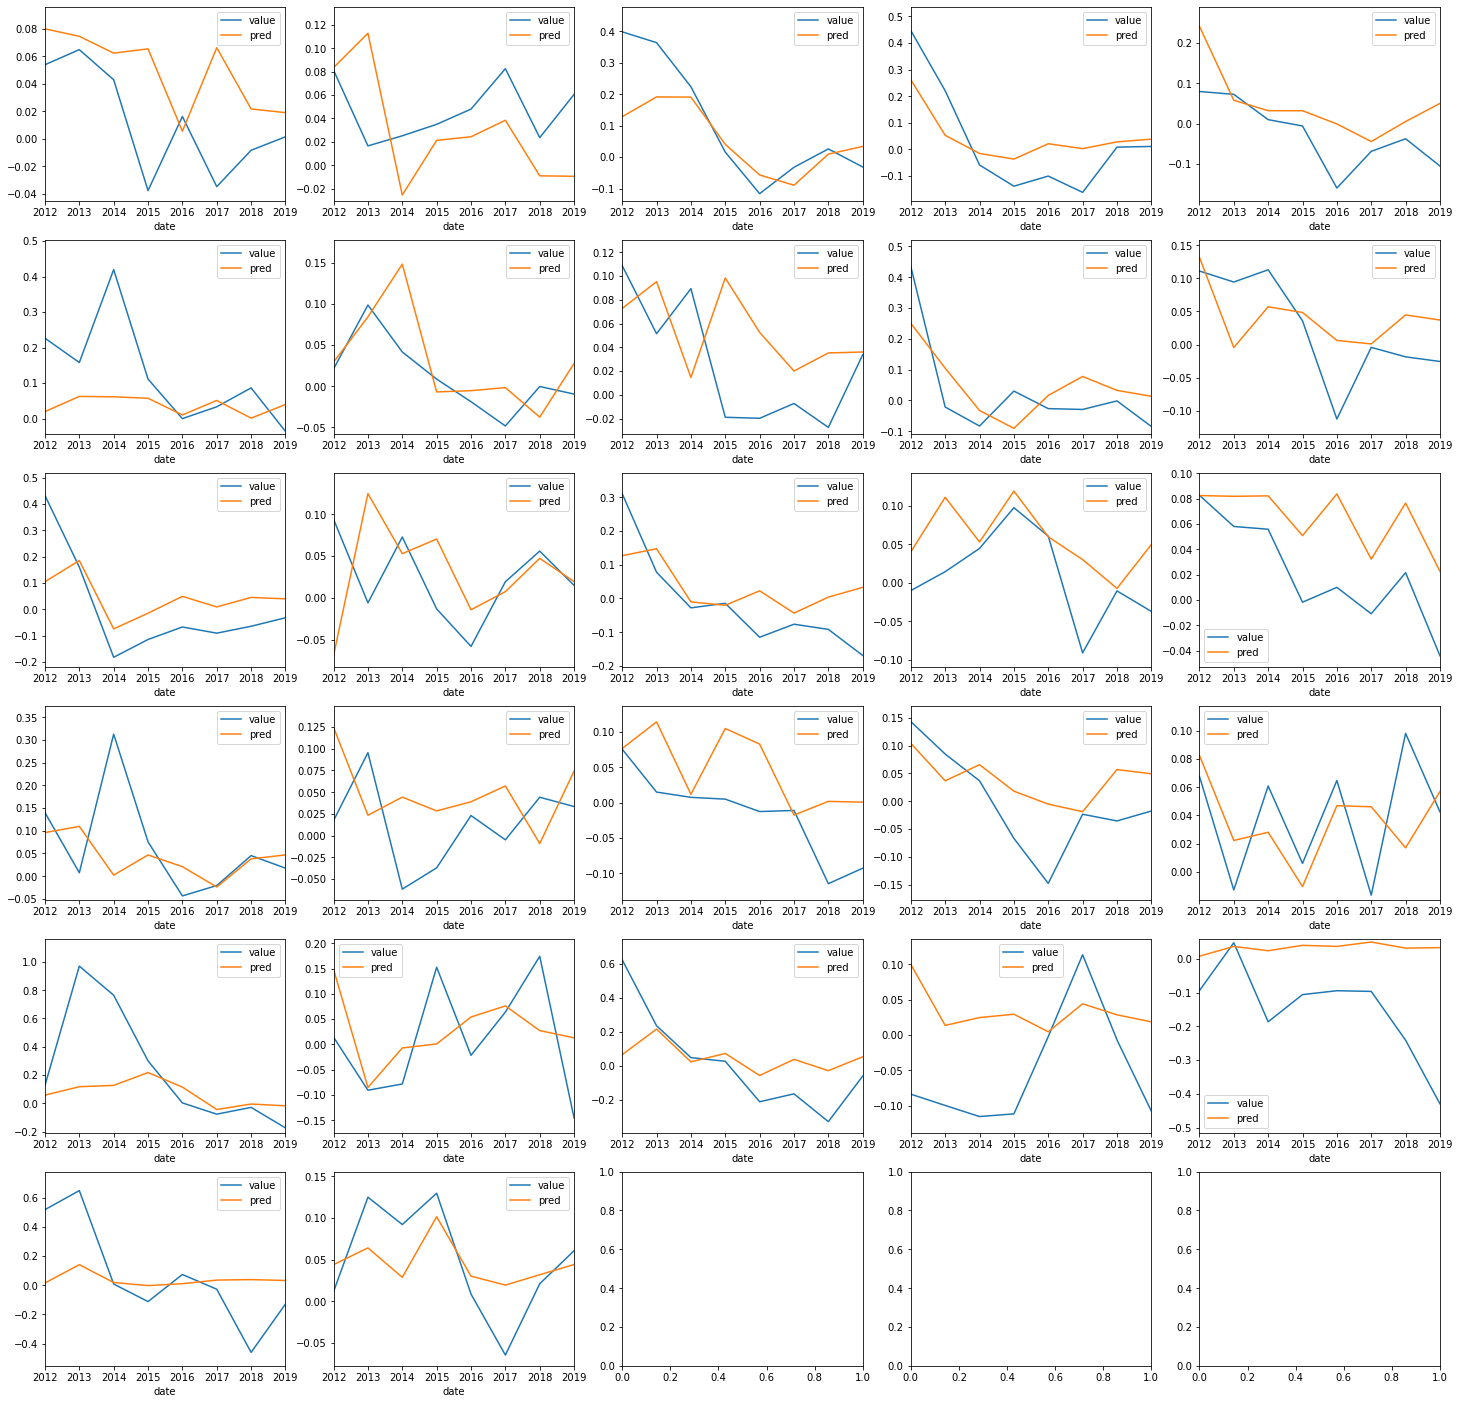

In [53]:
features = ["unempl", "share_young_pop", "gdp"] + keyword_ids + dummy_cols

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_core = linear_model.Lasso()
reg_pipeline = pipeline.make_pipeline(impute.KNNImputer(), reg_core)

params = {
    "lasso__alpha": [0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0],
}
tuner = model_selection.GridSearchCV(
    reg_pipeline, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])

lasso_coefs = reg.named_steps["lasso"].coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())



### GTI without lasso

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.032445    0.023599                                -3.270697   
1  0.021345    0.006780                                -3.270862   
2  0.008935    0.005077                                -7.828803   
3  0.008894    0.005853                              -212.244944   
4  0.006795    0.006773                               -13.089769   

   test_neg_root_mean_squared_error    test_r2  
0                         -0.274974  -1.510401  
1                         -0.306371  -0.566314  
2                         -0.259989  -3.045870  
3                         -0.172902  -3.422017  
4                         -0.233905 -14.156259

Mean CV score:


fit_time                                    0.015683
score_time                                  0.009616
test_neg_mean_absolute_percentage_error   -47.941015
test_neg_root_mean_squared_error           -0.249628
test_r2                                    -4.540172
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.418335
neg_root_mean_squared_error          -0.145078
r2                                   -0.607626
dtype: float64

2    -0.004398
10   -0.002614
11   -0.006167
12    0.003203
14   -0.001449
        ...   
PT    0.049324
RO    0.199036
SE    0.084032
SI    0.070254
SK    0.034343
Length: 75, dtype: float64

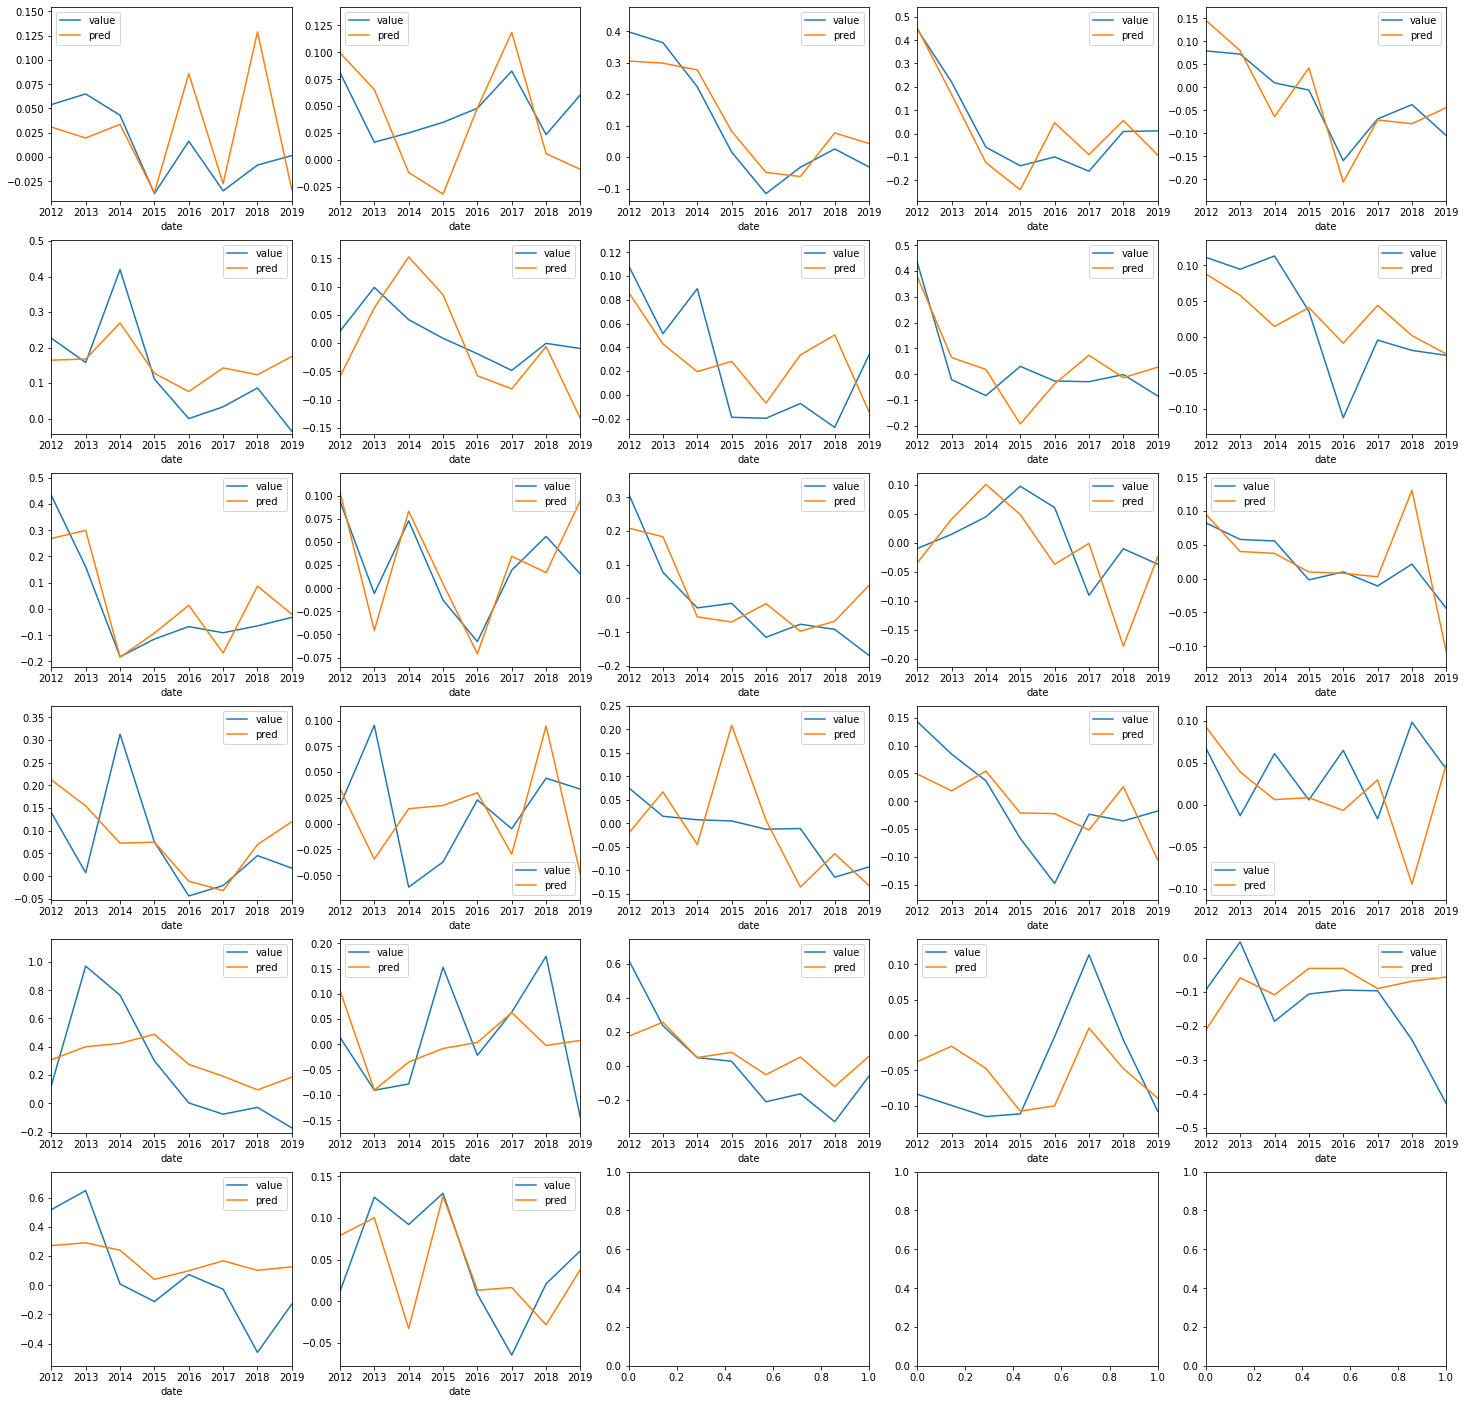

In [57]:
features = keyword_ids + dummy_cols

reg = linear_model.LinearRegression(fit_intercept=False)

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])

display(pd.Series(reg.coef_, index=features))



LASSO Coefficients:
prev1    0.0
prev2    0.0
2        0.0
10      -0.0
11       0.0
12       0.0
14      -0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22      -0.0
24       0.0
26       0.0
28       0.0
32       0.0
33       0.0
37       0.0
38       0.0
39       0.0
41       0.0
42       0.0
43       0.0
44       0.0
48       0.0
49       0.0
51       0.0
52       0.0
54       0.0
55       0.0
56       0.0
57      -0.0
58       0.0
59       0.0
60      -0.0
112      0.0
113      0.0
114     -0.0
115      0.0
117     -0.0
118      0.0
119     -0.0
121      0.0
122      0.0
123     -0.0
124     -0.0
125      0.0
AT      -0.0
BE      -0.0
BG       0.0
CH      -0.0
CY       0.0
CZ      -0.0
DK      -0.0
EE      -0.0
ES      -0.0
FI      -0.0
FR      -0.0
GB       0.0
GR      -0.0
HR       0.0
HU      -0.0
IE      -0.0
IT       0.0
LT      -0.0
LU       0.0
LV      -0.0
NL      -0.0
PL      -0.0
PT      -0.0
RO       0.0
SE      -0.0
SI   

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.004861    0.001972                                -0.996308   
1  0.002480    0.002240                                -0.913649   
2  0.003920    0.001821                                -2.309829   
3  0.002217    0.001742                               -35.889681   
4  0.002236    0.002844                                -2.651846   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.253834 -0.335671  
1                         -0.193729 -0.057260  
2                         -0.095888 -0.049532  
3                         -0.107440 -1.222945  
4                         -0.095300 -1.313928

Mean CV score:


fit_time                                   0.003143
score_time                                 0.002124
test_neg_mean_absolute_percentage_error   -8.552262
test_neg_root_mean_squared_error          -0.149238
test_r2                                   -0.595867
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -2.941599
neg_root_mean_squared_error          -0.133636
r2                                   -0.364033
dtype: float64

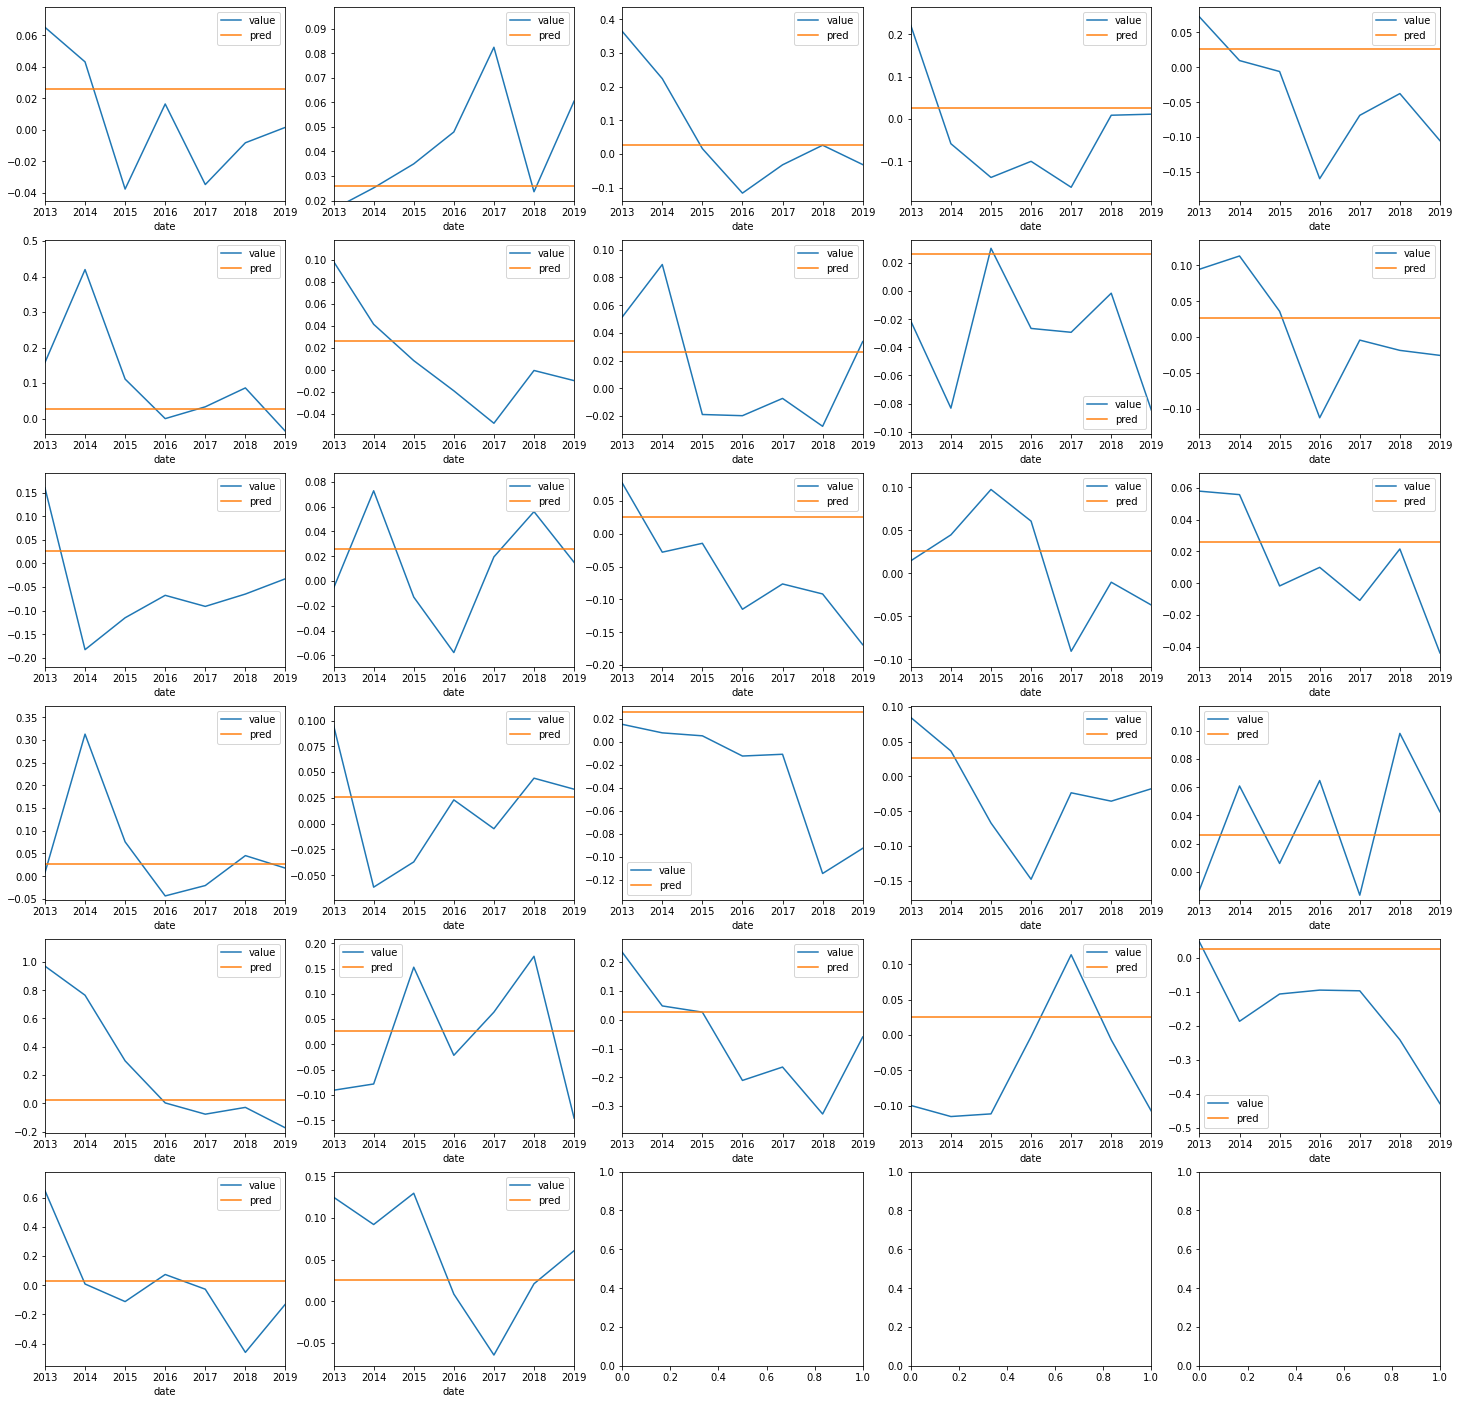

In [21]:
features = ["prev1", "prev2"] + keyword_ids + dummy_cols

reg = linear_model.Lasso()

reg.fit(x_train[features], y_train)

lasso_coefs = reg.coef_

print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])


# feature selection for additional regressors
# tf_1 = "passthrough"
# tf_2 = feature_selection.SelectKBest(feature_selection.f_regression, k=5)
# # tf_2 = feature_selection.SelectFromModel(
# #     linear_model.Lasso(normalize=True, alpha=20, positive=True)
# # )
# tf_3 = "passthrough"
# ct = compose.make_column_transformer(
#     (tf_1, ["prev1", "prev2"]), (tf_2, keyword_ids), (tf_3, dummy_cols)
# )

# reg = pipeline.make_pipeline(
#     ct,
#     linear_model.LinearRegression(),
#     # feature_selection.SequentialFeatureSelector(linear_model.LinearRegression(normalize=True), n_features_to_select=50),
#     # linear_model.LinearRegression(normalize=True),
# )
# reg = linear_model.Lasso(positive=True, alpha=0)
# reg = feature_selection.(linear_model.LinearRegression(), n_features_to_select=50, direction='forward')
# reg = linear_model.LinearRegression(positive=True).fit(x_train, y_train)
# reg = RandomForestRegressor().fit(x_train, y_train)

# reg.score(x_test, y_test)
# reg.fit(x_train, y_train)
# print(reg.coef_)
# df_pred
# print(y.to_numpy())
